# Getting Started with IViS & MeerKAT

This notebook demonstrates a basic example of using IViS’s single-frequency model to perform imaging with mosaicking, using five MeerKAT beams.

> **Note:** IViS takes Measurement Sets as input and expects a set of Primary Beam FITS files to be placed in the `BEAMS/` directory.

## Download

You can download the data directory `data_tutorials` using:

```bash
wget https://www.mso.anu.edu.au/~amarchal/shared/ivis/data_tutorials.zip
unzip data_tutorials.zip -d data_tutorials
rm data_tutorials.zip
```

Kindly provided by Enrico Di Teodoro (UniFI) and Karlie Noon (RSAA/ANU).

## Using IViS

In [10]:
import glob
from tqdm import tqdm as tqdm

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from radio_beam import Beam
from astropy import units as u
from reproject import reproject_interp

from ivis.io import DataProcessor
from ivis.imager import Imager
from ivis.logger import logger
from ivis.utils import dutils

from ivis.models import ClassicIViS

In [11]:
path_ms = "./data_tutorials/ivis_data/msl_mw/" #directory of measurement sets    
path_beams = "./data_tutorials/ivis_data/BEAMS/" #directory of primary beams
path_sd = "./data_tutorials/ivis_data/" #path single-dish data
pathout = "./data_tutorials/ivis_data/" #path where data will be packaged and stored

In [12]:
#REF WCS INPUT USER
filename = "./data_tutorials/ivis_data/MW-C10_mom0th_NHI.fits"
target_header = fits.open(filename)[0].header
shape = (target_header["NAXIS2"],target_header["NAXIS1"])
    
#create data processor
data_processor = DataProcessor(path_ms, path_beams, path_sd, pathout)

### Precompute PB and interpolation grid for mosaicking

In [13]:
# pre-compute pb and interpolation grids — this can be commented after first compute
logger.disabled = True
data_processor.compute_pb_and_grid(target_header, fitsname_pb="reproj_pb.fits", fitsname_grid="grid_interp.fits") 
logger.disabled = False

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


In [14]:
pb, grid = data_processor.read_pb_and_grid(fitsname_pb="reproj_pb.fits", fitsname_grid="grid_interp.fits")

### Set SD data if needed (not used here)

In [15]:
#Dummy sd array
sd = np.zeros(shape)
#Dummy Beam sd
beam_sd = Beam(1*u.deg, 1*u.deg, 1.e-12*u.deg)

### Choose user parameters

In [16]:
#user parameters
max_its = 20
lambda_sd = 0
lambda_r = 0.1
device = 0#"cpu" #0 is GPU and "cpu" is CPU
positivity = False

In [17]:
#init parameters
init_params = np.zeros(shape)

### Read data

In [18]:
#Read data
vis_data = data_processor.read_vis_from_scratch(uvmin=0, uvmax=np.inf,
                                                target_frequency=None,
                                                target_channel=0,
                                                extension=".ms",
                                                blocks='single',
                                                max_workers=1)

[2025-08-01 22:42:37 UTC] [IViS] [info] Processing single scheduling block.
[2025-08-01 22:42:37 UTC] [IViS] [info] Number of MS files = 5
[2025-08-01 22:42:37 UTC] [IViS] [info] Reading MS files with single thread.
[2025-08-01 22:42:37 UTC] [IViS] [info] Processing file 1/5: ./data_tutorials/ivis_data/msl_mw/MW-C10_1_MW_chan_-32kms.ms
[2025-08-01 22:42:37 UTC] [IViS] [info] Selected channel: 0 | Frequency: 1420557366.6050093 Hz | Velocity (LSRK): -32.0000000000517 km/s
[2025-08-01 22:42:37 UTC] [IViS] [info] Extracted 626313 valid baselines.
[2025-08-01 22:42:37 UTC] [IViS] [info] Time for iteration 1: 0.33s, ETA: 0.02 minutes
[2025-08-01 22:42:37 UTC] [IViS] [info] Processing file 2/5: ./data_tutorials/ivis_data/msl_mw/MW-C10_2_MW_chan_-32kms.ms
[2025-08-01 22:42:37 UTC] [IViS] [info] Selected channel: 0 | Frequency: 1420557366.6050096 Hz | Velocity (LSRK): -32.00000000010202 km/s
[2025-08-01 22:42:37 UTC] [IViS] [info] Extracted 1068720 valid baselines.
[2025-08-01 22:42:37 UTC] [IV

### Initialize Imager and process

In [20]:
# create image processor
image_processor = Imager(vis_data,      # visibilities
                         pb,            # array of primary beams
                         grid,          # array of interpolation grids
                         sd,            # single dish data in unit of Jy/arcsec^2
                         beam_sd,       # beam of single-dish data in radio_beam format
                         target_header, # header on which to image the data
                         init_params,   # init array of parameters
                         max_its,       # maximum number of iterations
                         lambda_sd,     # hyper-parameter single-dish
                         lambda_r,      # hyper-parameter regularization
                         positivity,    # impose a positivity constaint
                         device,        # device: 0 is GPU; "cpu" is CPU
                         beam_workers=1)
# choose model
model = ClassicIViS()
# get image
result = image_processor.process(model=model, units="Jy/arcsec^2") #"Jy/arcsec^2" or "K"

[2025-08-01 22:43:27 UTC] [IViS] [info] [Initialize Imager        ]
[2025-08-01 22:43:27 UTC] [IViS] [info] Number of iterations to be performed by the optimizer: 20
[2025-08-01 22:43:27 UTC] [IViS] [warning] lambda_sd = 0 - No short spacing correction (ignoring single dish data).
[2025-08-01 22:43:27 UTC] [IViS] [warning] CUDA not available. Falling back on CPU.
[2025-08-01 22:43:27 UTC] [IViS] [info] Starting optimisation (using LBFGS-B)
[2025-08-01 22:43:27 UTC] [IViS] [info] Optimizer not bounded - Positivity == False
[2025-08-01 22:43:33 UTC] [IViS] [info] [PID 73879] Total cost: 5.12948e+05
[2025-08-01 22:43:37 UTC] [IViS] [info] [PID 73879] Total cost: 4.52661e+09
[2025-08-01 22:43:39 UTC] [IViS] [info] [PID 73879] Total cost: 4.77059e+05
[2025-08-01 22:43:41 UTC] [IViS] [info] [PID 73879] Total cost: 4.70967e+05
[2025-08-01 22:43:42 UTC] [IViS] [info] [PID 73879] Total cost: 4.68327e+05
[2025-08-01 22:43:44 UTC] [IViS] [info] [PID 73879] Total cost: 4.66248e+05
[2025-08-01 22:4

### Compute effective PB for mosaic

In [21]:
#mean pb
filenames = sorted(glob.glob(path_beams+"*.fits"))
n_beams = len(filenames)
pb_all = np.zeros((n_beams,result.shape[0],result.shape[1]))
w = dutils.wcs2D(target_header)
for i in tqdm(np.arange(n_beams)):
    #open beam cube
    hdu_pb = fits.open(filenames[i])
    hdr_pb = hdu_pb[0].header
    pb2 = hdu_pb[0].data
    pb2[pb2 != pb2] = 0.
    w_pb = dutils.wcs2D(hdr_pb)
    pb2, footprint = reproject_interp((pb2,w_pb.to_header()), w.to_header(), shape)
    pb2[pb2 != pb2] = 0.
    pb_all += pb2
    pb_mean = np.nanmean(pb_all,0)
    pb_mean /= np.nanmax(pb_mean)    
    mask = np.where(pb_mean > 0.05, 1, np.nan)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.08s/it]


### Plot result

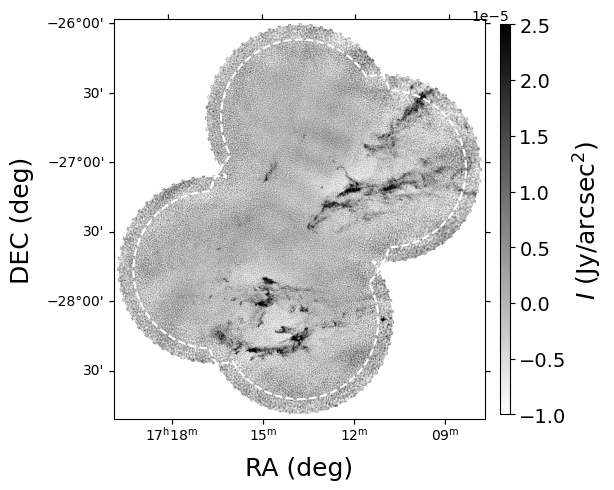

In [22]:
#PLOT RESULT
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=w)
ax.set_xlabel(r"RA (deg)", fontsize=18.)
ax.set_ylabel(r"DEC (deg)", fontsize=18.)
img = ax.imshow(result*mask, vmin=-1.e-5, vmax=2.5e-5, origin="lower", cmap="gray_r")
ax.contour(pb_mean, linestyles="--", levels=[0.05, 0.2], colors=["w","w"])
colorbar_ax = fig.add_axes([0.89, 0.11, 0.02, 0.78])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.ax.tick_params(labelsize=14.)
cbar.set_label(r"$I$ (Jy/arcsec$^{2})$", fontsize=18.)
#    plt.savefig(pathout + 'ivis_result_cloud_MeerKAT.png', format='png', bbox_inches='tight', pad_inches=0.02, dpi=400)